# Household Pulse Data Analysis

This analysis examines Long Covid (L.C.) prevalence across U.S. states and the District of Columbia, based on data from the U.S. Centers for Disease Control and Prevention (CDC) as of February 2024. We will explore potential predictors of L.C. rates and investigate statistical relationships between these factors. The dataset was curated by Julia Moore Vogel, and this analysis was conducted by Ashley Yaner. As advised by Julia Vogel, Baysian Variable selection, a statistical method used to identify the most relevant predictors or variables in a dataset, will be used to understand the most prevelant factors contributing to the rates of COVID per state. ---> Wordage similar to Bobby's

# Imports

Import packages

In [1]:
# !pip install pymc

^C


In [1]:
import pandas as pd
import re
import numpy as np
import datetime

# For plotting
import seaborn as sns  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

 # For dendrogram
import scipy.stats as stats
import scipy.cluster.hierarchy as shc 

# For Baysean variable selection
import pymc as pm
from sklearn.impute import SimpleImputer

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pm.__version__

'5.16.2'

# Configs

Path to the household pulse data csv

In [3]:
houshold_pulse_path = "LC_household_pulse_for_BV_9.csv"

# Load Data

In [4]:
def load_data(
    data_path: str
) -> pd.DataFrame:
    """Loads a CSV file into a pandas DataFrame.

    Args:
        data_path (str):
            The path to the CSV file to be loaded.

    Returns:
        df (pd.DataFrame):
            A pandas DataFrame containing the data from the
            loaded CSV file.

    Raises:
        FileNotFoundError: If the specified `data_path` does
        not exist.
    
    Typical Usage Example: 
        Load in a csv file with columnar data. 
        
        df = load_data("root/path_to_your_data/your_data.csv")  
    """

    try:
        df = pd.read_csv(data_path)
        
    except FileNotFoundError:
        print("Error: Check your file path. File not found at path:", data_path)
        raise
        
    return df

Import the houshold pulse data using pandas dataframe. 

In [5]:
df = load_data(houshold_pulse_path)

Inspect household pulse data dataframe. What does it contain?

In [6]:
df.head(10)

,State,Jul 24 Value,Jul 24 Low CI,Jul 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,...,45201,45229,45327,45355,45383,45411,45439,45467,45495,Avg
0,Alabama,5.5,3.7,7.7,57.7,42.3,50.0,29.0,12.0,8.0,...,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.475000
1,Alaska,5.4,3.8,7.5,64.9,35.1,34.0,37.0,23.0,6.0,...,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,6.975000
2,Arizona,4.9,3.6,6.5,89.3,10.7,39.0,31.0,23.0,7.0,...,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,6.800000
3,Arkansas,8.5,5.3,12.7,55.5,44.5,42.0,38.0,14.0,6.0,...,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.304167
4,California,6.2,4.8,7.8,94.2,5.8,31.0,34.0,29.0,6.0,...,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,5.875000
5,Colorado,5.7,4.3,7.4,86.0,14.0,33.0,34.0,28.0,5.0,...,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,6.608333
6,Connecticut,6.3,4.3,8.9,86.3,13.7,33.0,36.0,25.0,6.0,...,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,6.250000
7,Delaware,NaN,NaN,NaN,82.6,17.4,26.0,40.0,25.0,9.0,...,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,5.930435
8,District of Columbia,2.6,0.9,5.6,100.0,0.0,15.0,39.0,36.0,10.0,...,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.547619
9,Florida,4.2,2.9,5.9,91.5,8.5,37.0,31.0,24.0,8.0,...,5.6,5.0,6.3,6.7,6.4,4.8,5.5,5.3,4.2,5.562500


# Set States as Index

In [7]:
def set_states_as_idx(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Preprocesses a CSV file containing state-level data.
    
    Sets row names to values in the "State" column. Then, filters data
    to exclude rows where state column equals "United States".

    Args:
        df (pd.DataFrame):
            A pandas DataFrame containing the data from the
            loaded CSV file.

    Returns:
        df_states (pd.DataFrame):
            A preprocessed DataFrame with state names as row indices.

    Typical Usage Example: 
        This function is useful for preparing state-level data for
        analysis by:
            * Setting state names as row indices for easy identification
                and indexing.
            * Removing data for the United States if it's not relevant
                to your analysis.
            * Removing the "State" column to avoid redundancy.
            
        df_states= set_states_as_idx(df)

    The preprocessed DataFrame can then be used for various tasks, such
    as calculating statistics, creating visualizations, or performing
    machine learning models.
    """
    
    # Set state names as row indices
    df_states = df.copy()
    df_states.set_index("State", inplace=True)

    # Remove rows for the United States
    df_states = df_states.loc[df_states.index != "United States"]

    return df_states

In [8]:
df_states= set_states_as_idx(df)

In [9]:
df_states.head(10)

,Jul 24 Value,Jul 24 Low CI,Jul 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,...,45201,45229,45327,45355,45383,45411,45439,45467,45495,Avg
State,,,,,,,,,,,,,,,,,,,,,
Alabama,5.5,3.7,7.7,57.7,42.3,50.0,29.0,12.0,8.0,99.0,...,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.475000
Alaska,5.4,3.8,7.5,64.9,35.1,34.0,37.0,23.0,6.0,100.0,...,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,6.975000
Arizona,4.9,3.6,6.5,89.3,10.7,39.0,31.0,23.0,7.0,100.0,...,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,6.800000
Arkansas,8.5,5.3,12.7,55.5,44.5,42.0,38.0,14.0,6.0,100.0,...,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.304167
California,6.2,4.8,7.8,94.2,5.8,31.0,34.0,29.0,6.0,100.0,...,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,5.875000
Colorado,5.7,4.3,7.4,86.0,14.0,33.0,34.0,28.0,5.0,100.0,...,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,6.608333
Connecticut,6.3,4.3,8.9,86.3,13.7,33.0,36.0,25.0,6.0,100.0,...,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,6.250000
Delaware,NaN,NaN,NaN,82.6,17.4,26.0,40.0,25.0,9.0,100.0,...,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,5.930435
District of Columbia,2.6,0.9,5.6,100.0,0.0,15.0,39.0,36.0,10.0,100.0,...,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.547619


# Extract Long COVID Rates

In [13]:
def extract_lc_rates(
    df: pd.DataFrame,
    col_pattern: str
) -> pd.Series:
    """Extracts the Long COVID rate columns from a pandas DataFrame.

    Args:
        df (pd.DataFrame):
            The input DataFrame containing the household
            pulse data.
            
        col_pattern (str):
            A regular expression pattern for matching column names.

    Returns:
        lc_rates (pd.Series):
            A Series containing the extracted Long COVID rate data.
            
    Typical Usage Example: 
        This function is useful for extracting specific columns from
        a DataFrame based on a regular expression pattern. It can be
        used to isolate Long COVID rate data from a dataset for further
        analysis or visualization.
    
        lc_rates = extract_lc_rates(df_states, "^[0-9]+$")
        
            ^ Matches the beginning of the string.
            [0-9]+ Matches one or more digits (0-9).
            $ Matches the end of the string.
    """

    lc_rates_idx = [
        i for i,
        col in enumerate(df.columns) if re.match(col_pattern, col)
    ]
    
    lc_rates = df.iloc[:, lc_rates_idx]
    
    return lc_rates

In [14]:
# lc_rates = extract_lc_rates(df_states, "^X[0-9]+\\.[0-9]+\\.[0-9]+$")
lc_rates = extract_lc_rates(df_states, "^[0-9]+$")

In [15]:
lc_rates

,44753,44781,44830,44851,44879,44914,44942,44970,44998,45026,...,45173,45201,45229,45327,45355,45383,45411,45439,45467,45495
State,,,,,,,,,,,,,,,,,,,,,
Alabama,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,...,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5
Alaska,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,...,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4
Arizona,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,...,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9
Arkansas,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,...,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5
California,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,...,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2
Colorado,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,...,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7
Connecticut,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,...,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3
Delaware,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,...,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN
District of Columbia,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,...,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6


In [16]:
def convert_excel_dates(lc_rates):
    dates_converted = []

    # Convert 5-digit column headers to dates and format as strings
    for col in lc_rates.columns:
        excel_date = int(col) - 2  # Excel incorrectly treats 1900 as leap year AND starts at idx 1
        date_datetime = datetime.datetime(1900, 1, 1) + datetime.timedelta(days=excel_date)
        dates_converted.append(date_datetime.strftime('%m/%d/%Y'))

    return dates_converted

In [17]:
dates = convert_excel_dates(lc_rates)

In [18]:
dates

['07/11/2022',
 '08/08/2022',
 '09/26/2022',
 '10/17/2022',
 '11/14/2022',
 '12/19/2022',
 '01/16/2023',
 '02/13/2023',
 '03/13/2023',
 '04/10/2023',
 '05/08/2023',
 '06/19/2023',
 '07/10/2023',
 '08/07/2023',
 '09/04/2023',
 '10/02/2023',
 '10/30/2023',
 '02/05/2024',
 '03/04/2024',
 '04/01/2024',
 '04/29/2024',
 '05/27/2024',
 '06/24/2024',
 '07/22/2024']

In [19]:
len(dates)

24

## Convert matrix to vector

In [20]:
def matrix_to_vector(
    df: pd.DataFrame
) -> pd.Series:
    # Flatten dataframe. 
    lc_rates_flat = lc_rates.melt(ignore_index=False)['value']
    
    return lc_rates_flat

In [21]:
lc_rates_flat = matrix_to_vector(lc_rates)
print(lc_rates.shape)
print(len(lc_rates_flat))
print(f"lc_rates_flat min: {lc_rates_flat.min()}, {lc_rates_flat.max()}")

(51, 24)
1224
lc_rates_flat min: 2.0, 16.5


In [22]:
lc_rates_flat['Alabama']

State
Alabama     9.0
Alabama    11.2
Alabama     7.6
Alabama     8.0
Alabama     9.0
Alabama     6.8
Alabama     7.3
Alabama     5.7
Alabama     7.6
Alabama     7.3
Alabama     5.5
Alabama     7.7
Alabama     6.7
Alabama     7.1
Alabama     6.3
Alabama     8.8
Alabama     6.8
Alabama     7.9
Alabama     8.3
Alabama     7.4
Alabama     8.3
Alabama     8.6
Alabama     5.0
Alabama     5.5
Name: value, dtype: float64

# Normalize

## Compute Zscore

In [23]:
def compute_zscore_df(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Computes the z-score for all columns in a pandas DataFrame
  
    Args:
        df (pd.DataFrame):
            A pandas DataFrame.

    Returns:
        df_z_score (pd.DataFrame): 
            A new pandas DataFrame with the z-scores of each column.

          
    Typical Usage Example:
    
        Take a DataFrame and a column name as input, calculate the mean
        and standard deviation of the specified column, and return a new
        pandas Series containing the z-scores. This allows you to easily
        apply the z-score calculation to specific columns within your
        DataFrame.    
        
        df_z_scores =  compute_zscore_df(df)
  """

    # Select numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate mean and standard deviation for numeric columns
    df_means = numeric_df.mean(skipna=True)
    df_stds = numeric_df.std(skipna=True)

    # Calculate z-scores for numeric columns
    z_scores = (df[numeric_df.columns] - df_means) / df_stds

    # Fill missing values in z-scores with NaN
    z_scores = z_scores.fillna(np.nan)

    # Combine z-scores with original DataFrame
    # result_df = pd.concat([df, z_scores], axis=1)

    return z_scores

def compute_zscore_np(
    data: np.ndarray
) -> np.ndarray:
    """Computes the z-score for a NumPy array.

    Args:
        data (np.ndarray):
            A NumPy array.

    Returns:
        z_scores (np.ndarray):
            A NumPy array containing the z-scores of the input data.
    """
    # Remove NA values
    data = data[~np.isnan(data)]
    
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std

    return z_scores

In [24]:
lc_rates_flat_z_scores = compute_zscore_np(lc_rates_flat)

In [25]:
lc_rates_flat_z_scores.head(20)

State
Alabama                 1.637232
Alaska                  1.447871
Arizona                 2.015954
Arkansas                1.574112
California              0.374826
Colorado                0.816668
Connecticut             0.816668
Delaware               -1.645025
District of Columbia   -1.834386
Florida                 0.501066
Georgia                 0.122344
Hawaii                 -2.213108
Idaho                   2.584037
Illinois                1.195390
Indiana                 0.122344
Iowa                    2.079075
Kansas                  0.248585
Kentucky                2.268436
Louisiana               0.690427
Maine                   0.437946
Name: value, dtype: float64

In [28]:
def create_qq_plot(
    data: pd.Series
) -> None:
    """Creates a Q-Q plot of the specified Long COVID rate data.

    Args:
        lc_rates (pd.Series):
            A pandas Series containing the Z-Score of the 
            Long COVID rate data.

    Returns:
        None: The function directly creates the plot.
    """

    theoretical_quantiles = stats.norm.ppf(stats.rankdata(data) / (len(data) + 1))

    print(f"theoretical_quantiles min: {theoretical_quantiles.min()}, "\
          f"max: {theoretical_quantiles.max()}")
    print(f"data min: {data.min()}, max: {data.max()}")
    print(f"len(data): {len(data)}")
    
    plt.figure(figsize=(7, 7))

    # Add QQ line and data
    stats.probplot(data, dist="norm", plot=plt)
    
    # Access the scatter plot created by probplot
    scatter_plot = plt.gca().get_children()[0]
    
    # Modify the scatter plot properties
    scatter_plot.set_marker('o')  # Set marker to circles
    scatter_plot.set_markeredgecolor('black')  # Set edge color to black
    scatter_plot.set_markerfacecolor('white')  # Set face color to white for hollow
    scatter_plot.set_markersize(4)  # Adjust the marker size as needed

    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title("Normal Q-Q Plot")
    plt.grid(False)
    
    plt.show()

theoretical_quantiles min: -3.147854241451643, max: 3.1478542414516344
data min: -2.78119098549659, max: 6.371257354278543
len(data): 1215


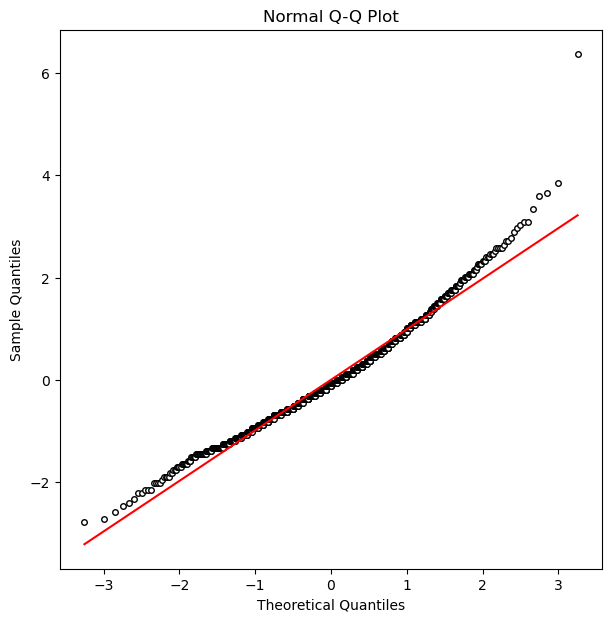

In [29]:
create_qq_plot(lc_rates_flat_z_scores)

In [30]:
lc_rates = lc_rates.set_axis(dates, axis=1)

In [31]:
lc_rates.head()

,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,...,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024
State,,,,,,,,,,,,,,,,,,,,,
Alabama,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,...,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5
Alaska,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,...,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4
Arizona,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,...,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9
Arkansas,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,...,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5
California,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,...,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2


In [32]:
lc_rates.columns

Index(['07/11/2022', '08/08/2022', '09/26/2022', '10/17/2022', '11/14/2022',
       '12/19/2022', '01/16/2023', '02/13/2023', '03/13/2023', '04/10/2023',
       '05/08/2023', '06/19/2023', '07/10/2023', '08/07/2023', '09/04/2023',
       '10/02/2023', '10/30/2023', '02/05/2024', '03/04/2024', '04/01/2024',
       '04/29/2024', '05/27/2024', '06/24/2024', '07/22/2024'],
      dtype='object')

In [33]:
def dendrogram(data):
    
    # Calculate the linkage matrix
    distance_matrix = shc.distance.pdist(data)  # Use pairwise distances
    linkage_matrix = shc.linkage(distance_matrix, method='ward')

    # Create the figure with a smaller size
    fig = plt.figure(figsize=(10, 7))
    # Create a gridspec layout
    gs = gridspec.GridSpec(
        1,
        2,
        width_ratios=[15, 85],
        figure=fig,
        wspace=0
    )

    axs = gs.subplots(sharex='col')
        
    # Create the dendrogram
    # axs[0] = plt.subplot(gs[0])
    dendrogram = shc.dendrogram(
        linkage_matrix,
        orientation='left',
        no_labels=True,
        ax=axs[0]
    )
    
    # Plot heatmap
    # axs[1] = plt.subplot(gs[1], sharex=ax1)
    
    data_index = data.index
    data_col_names = data.columns
    
    # Remove "State" from idx
    data = data.reset_index(drop=True)
    
    axs[1] = sns.heatmap(
        data,
        cbar=True,  # Display colorbar
        cmap="Reds",  # Choose a colormap (adjust as needed)
        linewidths=0.0,  # No lines between cells
        xticklabels=True,  # Show x-axis labels
        yticklabels=False  # Don't show y-axis labels
    )
    
    # Add y-axis labels to the right
    # Set the y-axis ticks and labels for ax[1]
    axs[1].set_yticks(range(len(data)))
    axs[1].set_yticklabels(data_index)

    # Set the y-axis ticks and labels for ax[1]
    axs[1].set_xticks(range(len(data_col_names)))
    axs[1].set_xticklabels(data_col_names)

    # Adjust the y-axis position for ax[1]
    axs[1].yaxis.tick_right()

    axs[1].tick_params(axis="y", left = False, labelleft=False) 
    
    plt.show()


In [34]:
print(f"Is NaN: {np.isnan(lc_rates_flat_z_scores).any()}")  # Checks for NaNs
print(f"Is INF: {np.isinf(lc_rates_flat_z_scores).any()}")  # Checks for infinities
print(f"Has Zeros: {(lc_rates_flat_z_scores == 0).any()}")  # Checks for infinities
print(lc_rates_flat_z_scores.dtype)

Is NaN: False
Is INF: False
Has Zeros: False
float64


In [37]:
lc_rates_zscore = compute_zscore_df(lc_rates)

In [38]:
# print(f"Is NaN: {np.isnan(lc_rates_zscore).any()}")  # Checks for NaNs
# print(f"Is INF: {np.isinf(lc_rates_zscore).any()}")  # Checks for infinities
# print(f"Has Zeros: {(lc_rates_zscore == 0).any()}")  # Checks for infinities

In [39]:
lc_rates_zscore.fillna(lc_rates_zscore.mean(), inplace=True)

In [40]:
lc_rates_zscore.index.nlevels

1

In [41]:
lc_rates_zscore.head()

,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,...,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024
State,,,,,,,,,,,,,,,,,,,,,
Alabama,0.668492,2.113911,0.014515,0.471193,1.611858,0.999512,0.727689,-0.296009,0.684017,0.645814,...,0.347730,2.070280,1.294332,0.588441,1.212185,0.245276,1.681910,1.979963,-0.494052,-0.248889
Alaska,0.508566,0.254661,0.268529,0.904182,0.861510,-0.415919,-0.946543,-0.498194,-0.904333,-0.818030,...,2.434108,-0.742684,-0.210705,1.406338,0.764204,0.815687,-0.076933,0.611284,0.689216,-0.323856
Arizona,0.988345,1.494161,-0.696724,0.417070,0.194535,0.237357,-0.248946,0.512731,0.684017,0.426237,...,0.794811,0.369418,0.326808,-0.418200,-0.206423,-0.467736,-0.279876,-0.073056,0.828425,-0.698689
Arkansas,0.615184,-0.139725,0.776557,1.824282,1.695229,0.999512,1.216007,0.175756,-0.139572,1.816889,...,-0.471919,0.173165,1.186829,0.651357,-0.131759,-0.681640,-0.347524,0.459208,0.619612,2.000108
California,-0.397684,0.705388,-0.645921,0.308823,-0.222325,-0.089281,-0.667504,-0.228614,-0.551366,-0.744838,...,-0.769973,-0.546431,-0.103203,-0.103625,0.390886,0.102674,-0.753411,-0.529282,-1.120489,0.275877


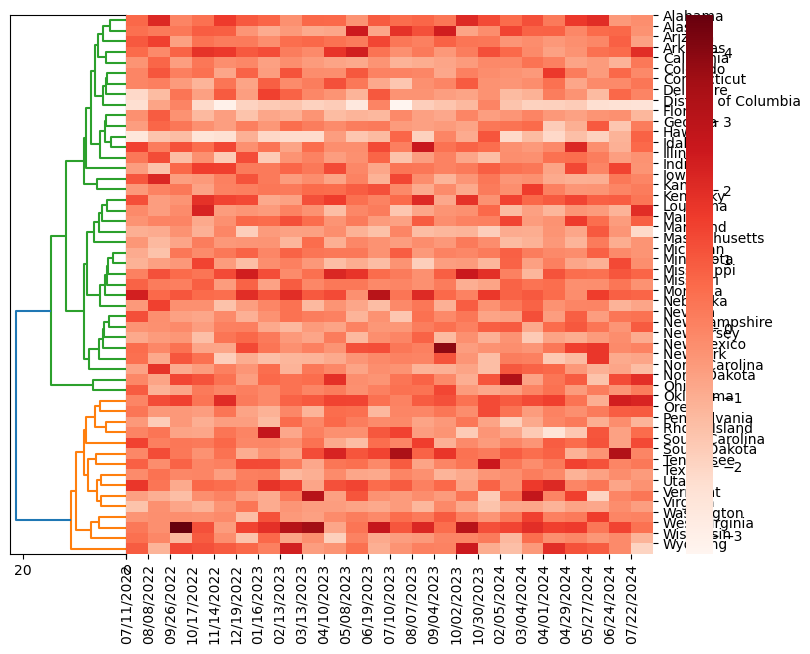

In [42]:
# TODO - MAKE PLOT PRETTIER BY MOVING COLORBAR !!!!!!!!!!!!!!!!!
dendrogram(lc_rates_zscore)

In [44]:
def get_variables_df(df, pattern="^[0-9]+$"):
    """ Gets variables from dataframe which may or may not
    contribute to the Long COVID rates.
    """
    
    # Exclude all columns which match the pattern
    exclude_mask = df.columns.astype(str).str.contains(pattern)

    # Filter columns based on the exclude mask
    df_filtered = df.loc[:, ~exclude_mask]
    
    df_filtered = df_filtered.drop(columns=['Avg'])
    
    return df_filtered

In [45]:
df_variables = get_variables_df(df_states, pattern="^[0-9]+$")

In [46]:
df_variables.head()

,Jul 24 Value,Jul 24 Low CI,Jul 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,...,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Eviction moratoria duration
State,,,,,,,,,,,,,,,,,,,,,
Alabama,5.5,3.7,7.7,57.7,42.3,50.0,29.0,12.0,8.0,99.0,...,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,59.0
Alaska,5.4,3.8,7.5,64.9,35.1,34.0,37.0,23.0,6.0,100.0,...,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,114.0
Arizona,4.9,3.6,6.5,89.3,10.7,39.0,31.0,23.0,7.0,100.0,...,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,0.0
Arkansas,8.5,5.3,12.7,55.5,44.5,42.0,38.0,14.0,6.0,100.0,...,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,0.0
California,6.2,4.8,7.8,94.2,5.8,31.0,34.0,29.0,6.0,100.0,...,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,884.0


In [47]:
def get_values_df(df1, df_values, col_to_add="Avg"):
    """ Adds the avg column back onto the lc_rates dataframe, 
    which contains all of the dates.
    """
    
    df_combined = pd.concat([df1[col_to_add], df_values], axis=1)
    
    return df_combined
    

In [48]:
lc_rates = get_values_df(df_states, lc_rates)
lc_rates

,Avg,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,...,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024
State,,,,,,,,,,,,,,,,,,,,,
Alabama,7.475000,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,...,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5
Alaska,6.975000,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,...,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4
Arizona,6.800000,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,...,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9
Arkansas,7.304167,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,...,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5
California,5.875000,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,...,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2
Colorado,6.608333,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,...,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7
Connecticut,6.250000,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,...,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3
Delaware,5.930435,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,...,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN
District of Columbia,3.547619,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,...,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6


In [49]:
def bayesian_variable_selection_with_dfs(
    df_vars: pd.DataFrame,
    series_values: pd.Series,
    target_col: str
) -> pm.backends.base.MultiTrace:
    """Performs Bayesian Variable Selection using PyMC3
    on a pandas DataFrame containing variables and a pandas
    Series containing Long COVID rates.

    Args:
      df_vars (pandas.DataFrame):
          DataFrame containing variables afftecting/not
          affecting Long COVID Rates.
          
      series_values (pd.Series):
          DataFrame containing Long COVID rates.
          
      target_col (str):
          The column name of the target column in df_values. 
          This can contains either a specific date or avg of 
          all dates of Long COVID rates.

    Returns:
      trace (pm.backends.base.MultiTrace):
          A PyMC3 trace object containing the Baysian Variable
          Selection results.
    """
    # Extract data from DataFrames
    y = series_values.values  # Long COVID rates
    X = df_vars.values  # Variables affecting/not affecting LC rates

    # Impute missing values using SimpleImputer.
    # Replace 'mean' with 'median' or 'most_frequent' if needed
    imputer = SimpleImputer(strategy='mean')  
    X_imputed = imputer.fit_transform(X)    
    
    n, p = X.shape

    with pm.Model() as model:
        # ------------------------------------------------------------------------------
        # Priors
        # ------------------------------------------------------------------------------
        # sigma defines a prior distribution for the std of the noise term in 
        # the model. It uses a half-Cauchy distribution with a scale parameter
        # beta=1. This distribution is heavy-tailed, meaning it allows for a
        # wide range of possible values for the std, reflecting uncertainty
        # about the noise level. A beta parameter of 1 indicates a relatively
        # flat prior, meaning it doesn't strongly favor any particular scale of
        # the distribution. This is often desirable when we have limited prior
        # knowledge or want to let the data drive the inference.
        sigma = pm.HalfCauchy('sigma', beta=1)
        # beta_raw defines a prior distribution for a vector of raw coefficients 
        # associated with each feature in the data. It uses a normal distribution
        # with a mean of 0 and a std of 1 for each element of beta_raw. A mean of
        # 0 indicates a neutral prior, meaning it doesn't favor any particular
        # value of the parameter. Setting std to 1 means the prior distribution
        # is scale-invariant, meaning the choice of units doesn't affect the
        # inference. The shape=p argument specifies that beta_raw will be a vector of 
        # length p, where p is the number of features in your data.
        beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, shape=p)
        # ind defines a prior distribution for a vector of indicator variables
        # for each feature. It uses a Bernoulli distribution with a probability of
        # success (p=0.2) for each element of ind. This means there's a 20% chance for
        # each element to be 1 (indicating inclusion) and an 80% chance to be 0
        # (exclusion). Setting p=0.2 can be seen as a sparsity assumption, a form of 
        # regularization, of for use in computational efficiency. Rgarding the sparsity
        # assumption, many real-world problems exhibit sparsity, meaning only a small
        # subset of features are truly informative. Rgarding regularization, setting 
        # p=0.2, the model is encouraged to favor simpler models with fewer active
        # features, which helps prevent overfitting. With respect to computational 
        # efficiency, using a smaller p value can lead to computational efficiency gains,
        # especially in high-dimensional problems, as it reduces the number of features
        # that need to be considered. The shape=p argument ensures ind has the same
        # length as beta_raw.
        ind = pm.Bernoulli('ind', p=0.2, shape=p)
        # This defines a deterministic variable (beta) that combines the raw
        # coefficients (beta_raw) and the indicator variables (ind). The element-wise
        # multiplication (*) ensures that features with corresponding ind values of 0
        # get effectively set to 0 in beta. This is how variable selection is achieved
        # through the interaction of priors. Features with low selection probability
        # (low ind values) will have their coefficients shrunk towards 0 in the posterior
        # distribution.
        beta = pm.Deterministic('beta', beta_raw * ind)

        # ------------------------------------------------------------------------------
        # Likelihood
        # ------------------------------------------------------------------------------
        # mu defines a deterministic variable (mu) that represents the predicted mean of
        # the response variable (y).It uses the dot product (pm.math.dot) between the
        # imputed data matrix (X_imputed) and the coefficient vector (beta) to calculate
        # the predicted means for each data point.
        mu = pm.Deterministic('mu', pm.math.dot(X_imputed, beta))
        # likelihood defines the likelihood function, representing the probability of 
        # observing the actual data (y) given the predicted means (mu) and the assumed 
        # noise distribution. It uses a normal distribution with the predicted means
        # (mu) as the expected values and the standard deviation (sigma) from the 
        # prior. The observed data (y) is used to compute the likelihood for each data
        # point.
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

        # ------------------------------------------------------------------------------
        # Sampling
        # ------------------------------------------------------------------------------
        # This performs Markov chain Monte Carlo (MCMC) sampling using the PyMC3 library.
        # It samples 500 posterior draws from the joint distribution of all model
        # parameters after an initial tuning phase of 100 draws (tune). The cores=4
        # argument (optional) enables parallel sampling using 4 CPU cores, if available,
        # to speed up the process.
        # Trace is is the result of the the MCMC, which contains information about the
        # sampled parameter values after the model has been fit.
        trace = pm.sample(500, tune=100, cores=4)        

    return trace

In [50]:
def bayesian_variable_selection_multiple(
    df_vars: pd.DataFrame,
    df_values: pd.DataFrame,
) -> list:
    """
    Performs Bayesian Variable Selection for multiple target
    variables in two pandas DataFrames, one containing variables and
    the other containing Long COVID rates (for different dates and also
    an accumulated avg).

    Args:
        df_vars (pandas.DataFrame):
            The input DataFrame containing the variables.
            
        df_values (pandas.DataFrame):
            The input DataFrame containing the Long COVID rates.
    Returns:
        traces (list):
            A list of PyMC trace objects, one for each target variable, 
            containing the Baysian Variable Selection results. 
    """

    traces = []  # init list to store results of BVS
    
    # Iterate through columns in Long COVID rate dataframe
    for target_col in df_values.columns:
        
        trace = bayesian_variable_selection_with_dfs(
            df_vars,  # dataframe containing variables
            df_values[target_col],  # series containing Long COVID rates
            target_col  # corresponding column header to rate values
        )
        
        traces.append(trace)  # append BVS results to list

    return traces

In [51]:
# target_cols = lc_rates.columns
# target_cols
lc_rates.columns

Index(['Avg', '07/11/2022', '08/08/2022', '09/26/2022', '10/17/2022',
       '11/14/2022', '12/19/2022', '01/16/2023', '02/13/2023', '03/13/2023',
       '04/10/2023', '05/08/2023', '06/19/2023', '07/10/2023', '08/07/2023',
       '09/04/2023', '10/02/2023', '10/30/2023', '02/05/2024', '03/04/2024',
       '04/01/2024', '04/29/2024', '05/27/2024', '06/24/2024', '07/22/2024'],
      dtype='object')

In [52]:
lc_avg = pd.DataFrame(lc_rates["Avg"])
lc_avg.columns

Index(['Avg'], dtype='object')

In [ ]:
all_variables_avg = bayesian_variable_selection_multiple(df_variables, lc_avg)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, beta_raw]
>BinaryGibbsMetropolis: [ind]


Output()